In [1]:
# Setup and Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from train import train
from model_test import *
from atk import ATTACK_CONFIGS
import torch.optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from model import *
import os
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Training configurations
configs = [
    {'name': 'NonSpiking_WideResNet16_Clean', 'use_spike': False, 'atk': 'none', 'lr': 0.01, 'batch_size': 64, 'epochs': 50},
    {'name': 'NonSpiking_WideResNet16-GN', 'use_spike': False, 'atk': 'gn', 'lr': 0.01, 'batch_size': 64, 'epochs': 50},
    {'name': 'NonSpiking_WideResNet16-PGD', 'use_spike': False, 'atk': 'pgd', 'lr': 0.01, 'batch_size': 64, 'epochs': 50},
    {'name': 'Spiking_WideResNet16-Clean', 'use_spike': True, 'atk': 'none', 'model_size': 18, 'lr': 0.01, 'batch_size': 64, 'epochs': 50, 'T': 4},
    {'name': 'Spiking_WideResNet16-GN', 'use_spike': True, 'atk': 'gn', 'model_size': 18, 'lr': 0.01, 'batch_size': 64, 'epochs': 50, 'T': 4},
    {'name': 'Spiking_WideResNet16-PGD', 'use_spike': True, 'atk': 'pgd', 'model_size': 18, 'lr': 0.01, 'batch_size': 64, 'epochs': 50, 'T': 4}
]

In [4]:
# Training Phase

In [5]:
# Train models with updated parameters
training_results = {}

for config in configs:
    print(f"\nTraining {config['name']}...")
    
    # Extract training parameters with defaults
    model_type = config.get('model_type', 'standard')
    use_spike = config.get('use_spike', False)
    print(use_spike)
    atk = config.get('atk', 'none')
    epochs = 10 # config.get('epochs', 10)
    batch_size = config.get('batch_size', 64)
    lr = 0.001#config.get('lr', 0.1)
    T = config.get('T', 4)
    optimizer = 'adamw'
    
    # Train model with optimized parameters
    result = train(
        #model_type=model_type,
        use_spike=use_spike,
        atk=atk,
        epochs=epochs,
        batch_size=batch_size,
        lr=lr,
        T=T,
        optimizer_type=optimizer
    )
    
    # Store results
    training_results[config['name']] = result
    print(f"Training completed for {config['name']}")
    print(f"Final test accuracy: {result['best_acc']:.2f}%")
    print(f"Model saved to: ./weight/{model_type}_spike_{use_spike}_atk_{atk}.pth")


Training NonSpiking_WideResNet16_Clean...
False
Training on 6000 samples, testing on 1000 samples
Attack type: none, Optimizer: adamw
Using standard WideResNet16
Epoch [1/10], Train Loss: 0.5397, Train Acc: 85.62%, Test Acc: 72.30%
New best model saved with accuracy: 72.30%
Epoch [2/10], Train Loss: 0.1039, Train Acc: 97.12%, Test Acc: 85.50%
New best model saved with accuracy: 85.50%
Epoch [3/10], Train Loss: 0.0932, Train Acc: 97.42%, Test Acc: 97.40%
New best model saved with accuracy: 97.40%
Epoch [4/10], Train Loss: 0.0588, Train Acc: 98.25%, Test Acc: 98.50%
New best model saved with accuracy: 98.50%
Epoch [5/10], Train Loss: 0.0430, Train Acc: 98.53%, Test Acc: 97.40%
Epoch [6/10], Train Loss: 0.0351, Train Acc: 98.97%, Test Acc: 95.10%
Epoch [7/10], Train Loss: 0.0294, Train Acc: 99.18%, Test Acc: 98.70%
New best model saved with accuracy: 98.70%
Epoch [8/10], Train Loss: 0.0261, Train Acc: 99.08%, Test Acc: 98.00%
Epoch [9/10], Train Loss: 0.0231, Train Acc: 99.23%, Test Acc:

In [6]:
# Training Results Visualization

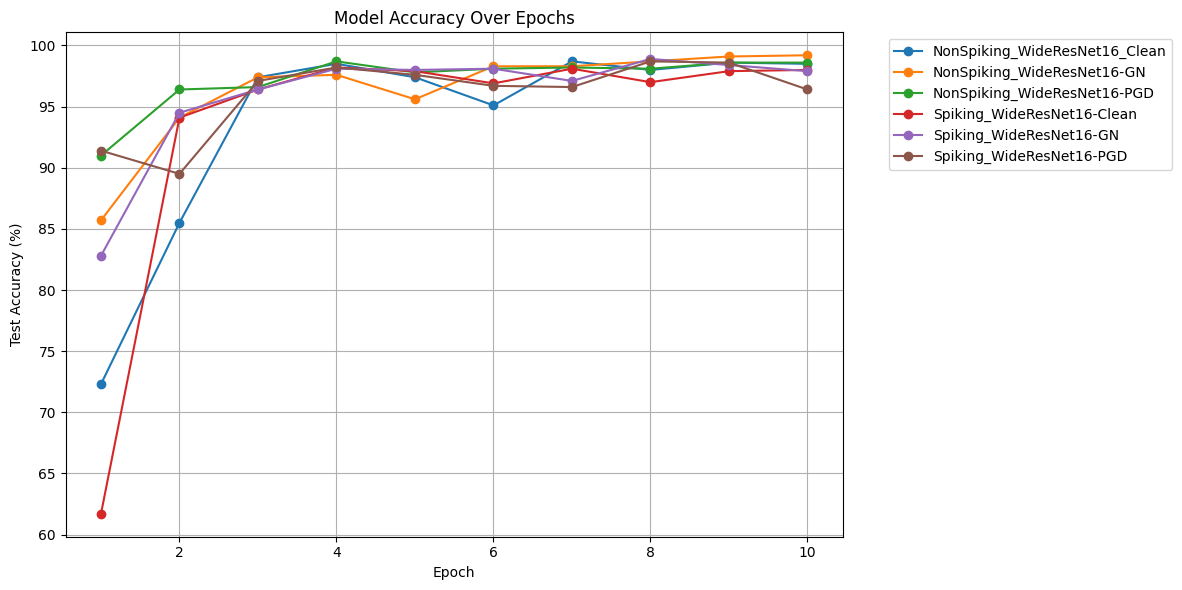

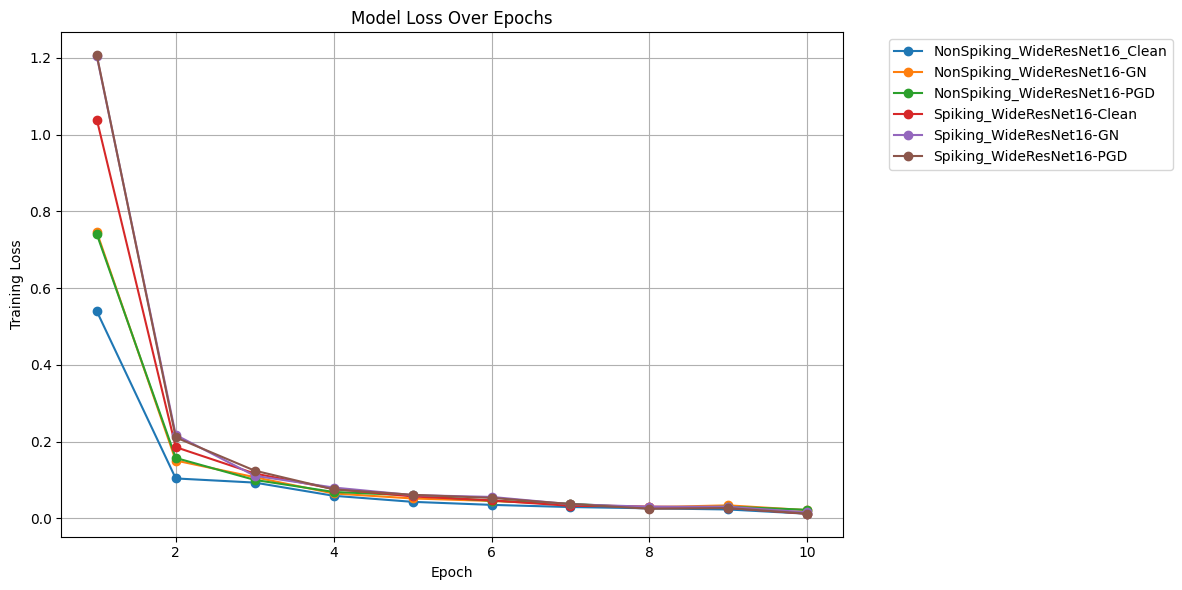

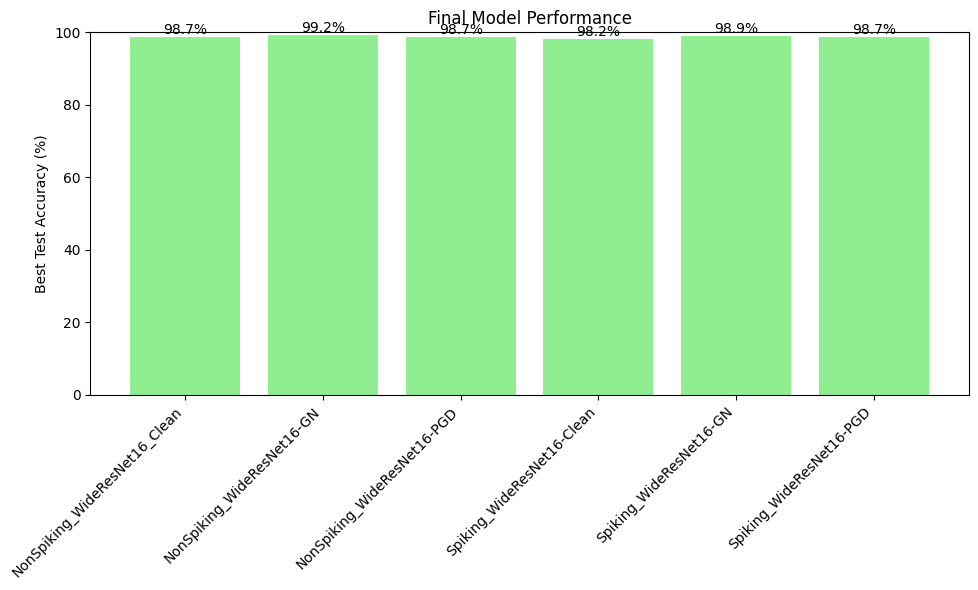


=== FINAL METRICS ===
Model Name                     Final Accuracy  Final Loss     
------------------------------------------------------------
NonSpiking_WideResNet16_Clean  98.50           0.0119         
NonSpiking_WideResNet16-GN     99.20           0.0213         
NonSpiking_WideResNet16-PGD    98.60           0.0222         
Spiking_WideResNet16-Clean     98.00           0.0118         
Spiking_WideResNet16-GN        97.90           0.0155         
Spiking_WideResNet16-PGD       96.40           0.0122         


In [7]:
def plot_training_progress(training_results):
    """
    Creates separate plots for accuracy and loss over epochs for each model
    """
    # Create figure for accuracy
    plt.figure(figsize=(12, 6))
    
    # Plot accuracy for each model
    for model_name, result in training_results.items():
        accuracies = result['test_accuracies']
        epochs = range(1, len(accuracies) + 1)
        plt.plot(epochs, accuracies, marker='o', label=model_name)
    
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Model Accuracy Over Epochs')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Create figure for loss
    plt.figure(figsize=(12, 6))
    
    # Plot loss for each model
    for model_name, result in training_results.items():
        losses = result['train_losses']
        epochs = range(1, len(losses) + 1)
        plt.plot(epochs, losses, marker='o', label=model_name)
    
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Model Loss Over Epochs')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Create figure for final accuracies
    plt.figure(figsize=(10, 6))
    model_names = list(training_results.keys())
    final_accuracies = [result['best_acc'] for result in training_results.values()]
    
    # Create bar chart with color coding
    colors = ['lightblue' if 'spike' in name.lower() else 'lightgreen' for name in model_names]
    bars = plt.bar(range(len(model_names)), final_accuracies, color=colors)
    
    # Add accuracy values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')
    
    plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
    plt.ylim([0, 100])
    plt.ylabel('Best Test Accuracy (%)')
    plt.title('Final Model Performance')
    plt.tight_layout()
    plt.show()
    
    # Print final metrics for each model
    print("\n=== FINAL METRICS ===")
    print(f"{'Model Name':<30} {'Final Accuracy':<15} {'Final Loss':<15}")
    print("-" * 60)
    for model_name, result in training_results.items():
        final_acc = result['test_accuracies'][-1]
        final_loss = result['train_losses'][-1]
        print(f"{model_name:<30} {final_acc:<15.2f} {final_loss:<15.4f}")

# Call the plotting function after training
plot_training_progress(training_results)

In [8]:
for config_name, result in training_results.items():
    print(config_name, result)

NonSpiking_WideResNet16_Clean {'best_acc': 98.7, 'train_losses': [0.5396906590842186, 0.10394452514245789, 0.09315423852704624, 0.0587785915580598, 0.043012061329717015, 0.03508028344429554, 0.02942459628065216, 0.026129796817413273, 0.023077149344162343, 0.011944340230795516], 'train_accuracies': [85.61666666666666, 97.11666666666666, 97.41666666666667, 98.25, 98.53333333333333, 98.96666666666667, 99.18333333333334, 99.08333333333333, 99.23333333333333, 99.63333333333334], 'test_accuracies': [72.3, 85.5, 97.4, 98.5, 97.4, 95.1, 98.7, 98.0, 98.6, 98.5]}
NonSpiking_WideResNet16-GN {'best_acc': 99.2, 'train_losses': [0.7459014624832793, 0.1506449653905757, 0.10721184273666524, 0.06479466772895862, 0.051792343384883505, 0.04528898245437031, 0.03636320658335264, 0.029094490678386487, 0.033840691259606405, 0.02128998067990401], 'train_accuracies': [78.31666666666666, 95.81666666666666, 96.75, 98.01666666666667, 98.26666666666667, 98.56666666666666, 98.86666666666666, 99.2, 98.95, 99.3333333

In [9]:
# Test models with different attacks
test_results = {}

# List of attack types to test
attack_types = ['none', 'gn', 'pgd']

# List of model configurations to test
model_configs = [
    {"name": "NonSpiking_WideResNet16_Clean", "use_spike": False, "train_attack": "none"},
    {"name": "NonSpiking_WideResNet16-GN", "use_spike": False, "train_attack": "gn"},
    {"name": "NonSpiking_WideResNet16-PGD", "use_spike": False, "train_attack": "pgd"},
    {"name": "Spiking_WideResNet16-Clean", "use_spike": True, "train_attack": "none"},
    {"name": "Spiking_WideResNet16-GN", "use_spike": True, "train_attack": "gn"},
    {"name": "Spiking_WideResNet16-PGD", "use_spike": True, "train_attack": "pgd"}
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Increase batch size for testing
test_batch_size = 256

for config in model_configs:
    config_name = config["name"]
    use_spike = config["use_spike"]
    train_attack = config["train_attack"]
    optimizer = 'adamw'  # Default optimizer
    
    model_path = f"./weight/standard_spike_{use_spike}_atk_{train_attack}_{optimizer}.pth"
    print(f"\nTesting {model_path}...")
    
    # Load model once for all attacks
    model = get_model(use_spike=use_spike)
    
    try:
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        model.eval()
        
        # Dictionary to store accuracies for this model
        model_results = {}
        
        # Test with different attacks
        for attack in attack_types:
            print(f"  Testing with {attack} attack...")
            acc, class_accs, conf_matrix = test(
                model=model,
                attack_type=attack,
                batch_size=test_batch_size,
                device=device,
                optimizer=optimizer
            )
            
            model_results[attack] = {
                'accuracy': acc,
                'class_accuracies': class_accs,
                'confusion_matrix': conf_matrix
            }
            
            print(f"    Accuracy: {acc:.2f}%")
        
        test_results[config_name] = model_results
    except Exception as e:
        print(f"Error testing {config_name}: {e}")
        test_results[config_name] = {'error': str(e)}


Testing ./weight/standard_spike_False_atk_none_adamw.pth...
Using standard WideResNet16
  Testing with none attack...
In test function, attack_type: none, optimizer: adamw
Model is non-spiking
Model has 2748614 parameters

DEBUG INFORMATION:
Sample predictions:

Sample outputs for none:
  Sample 0: Label=5, Predicted=5
  Logits: [-5.23741   -6.6166005 -6.5267043 -0.9789753 -5.606622  10.506854
 -4.336094  -6.5390606 -1.916178  -1.8112926]
  Sample 1: Label=3, Predicted=3
  Logits: [-4.866591   -5.818457   -3.629456    7.2364273  -3.725484    1.5297163
 -6.1882725  -4.586104   -1.5180264   0.20019017]
  Sample 2: Label=7, Predicted=7
  Logits: [-3.2149768  -3.116949    0.2413196  -1.5762368  -3.4226744  -4.4700084
 -5.802057    6.585427   -3.928787   -0.42183298]
  Sample 3: Label=4, Predicted=4
  Logits: [-3.8640263 -5.3211594 -4.115743  -5.4421115  7.075147  -3.682255
 -4.9336615 -4.5237246 -3.2066057  2.7505894]
  Sample 4: Label=1, Predicted=1
  Logits: [-4.4573708 10.197101  -4.47


DEBUG INFORMATION:
Sample predictions:

Sample outputs for pgd:
  Sample 0: Label=2, Predicted=3
  Logits: [-4.2125735 -1.5796742  0.7605925  2.5671387 -4.3276916  1.1976786
 -2.432312  -2.8357403 -1.8947916 -3.203174 ]
  Sample 1: Label=3, Predicted=3
  Logits: [-4.5902853 -2.8840578 -1.5266796  4.660476  -4.6811333  2.374467
 -3.8515353 -2.0365076 -2.045161  -1.7774756]
  Sample 2: Label=3, Predicted=5
  Logits: [-4.4898176 -2.7860458 -1.0312846  3.1163025 -4.5257025  3.2447176
 -2.9455914 -2.8128157 -2.1685345 -2.507377 ]
  Sample 3: Label=8, Predicted=5
  Logits: [-2.7832005  -2.3913755  -1.8569211  -2.849546   -2.9945302   2.6994407
 -0.9799844  -2.4578798   0.69442976 -1.4750224 ]

Per-class accuracy:
  Class 0: 59.74%
  Class 1: 98.32%
  Class 2: 84.35%
  Class 3: 86.27%
  Class 4: 70.00%
  Class 5: 100.00%
  Class 6: 90.11%
  Class 7: 64.71%
  Class 8: 14.85%
  Class 9: 70.00%
    Accuracy: 74.40%

Testing ./weight/standard_spike_True_atk_gn_adamw.pth...
Using WideResNet16 wit

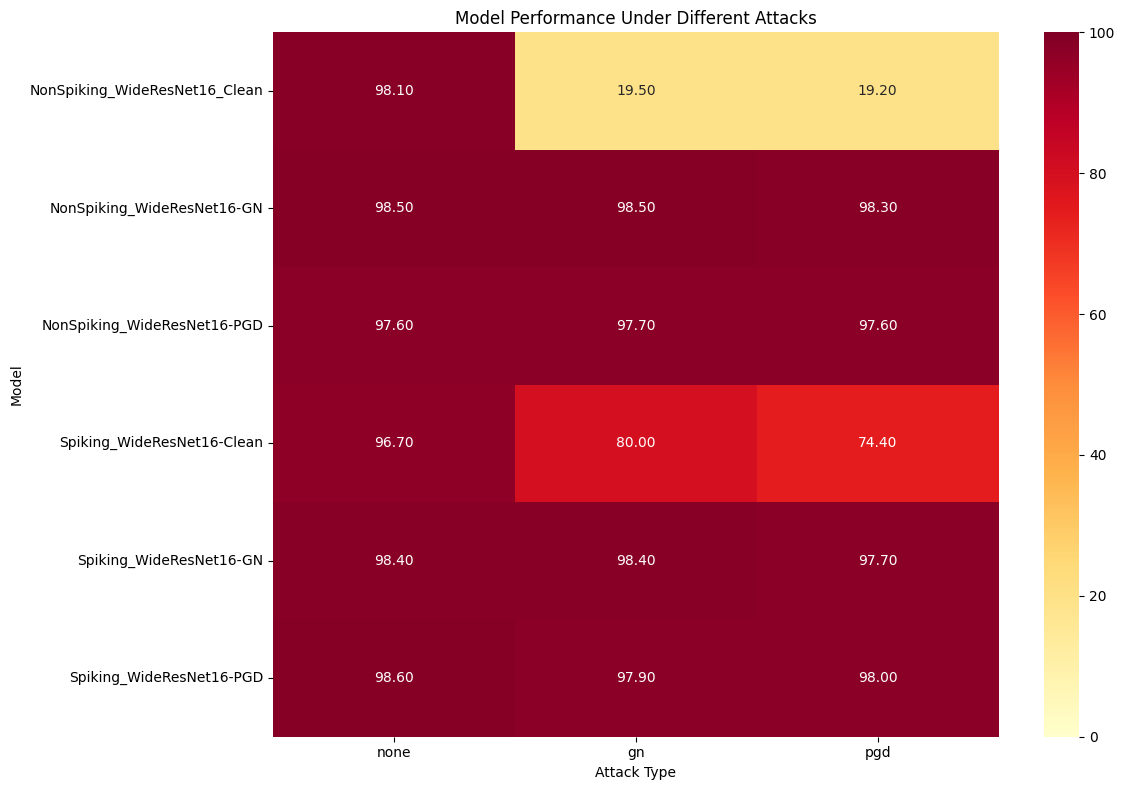

In [10]:
# Get model names and attack types
model_names = list(test_results.keys())
attack_names = ['none', 'gn', 'pgd']  # Make sure these match your attack types

if not model_names:
    print("No models were successfully tested. Please check the debug output above.")
else:
    # Initialize the comparison matrix with NaN values
    comparison_matrix = np.full((len(model_names), len(attack_names)), np.nan)
    
    # Fill the matrix with accuracies
    for i, model_name in enumerate(model_names):
        for j, attack_name in enumerate(attack_names):
            if attack_name in test_results[model_name]:
                comparison_matrix[i, j] = test_results[model_name][attack_name]['accuracy']
    
    # Check if we have any valid values
    if np.isnan(comparison_matrix).all():
        print("No valid accuracy values found in the results.")
    else:
        # Create heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(comparison_matrix, 
                    annot=True, 
                    fmt='.2f',
                    xticklabels=attack_names,
                    yticklabels=model_names,
                    cmap='YlOrRd',
                    vmin=0,  # Set minimum value to 0
                    vmax=100)  # Set maximum value to 100 for accuracy percentage

        plt.title('Model Performance Under Different Attacks')
        plt.xlabel('Attack Type')
        plt.ylabel('Model')
        plt.tight_layout()
        plt.show()

In [11]:
# Per-Class Analysis
test_results

{'NonSpiking_WideResNet16_Clean': {'none': {'accuracy': 98.1,
   'class_accuracies': [99.01960784313725,
    98.23008849557522,
    99.01960784313725,
    100.0,
    100.0,
    97.59036144578313,
    97.77777777777777,
    97.3913043478261,
    95.78947368421052,
    96.15384615384616],
   'confusion_matrix': array([[101.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
          [  0., 111.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0., 101.,   1.,   0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,  93.,   0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   0., 103.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   2.,   0.,  81.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   0.,   0.,   2.,  88.,   0.,   0.,   0.],
          [  0.,   1.,   0.,   1.,   1.,   0.,   0., 112.,   0.,   0.],
          [  0.,   0.,   0.,   3.,   0.,   1.,   0.,   0.,  91.,   0.],
          [  0.,   0.,   0.,   0.,   4.,   0

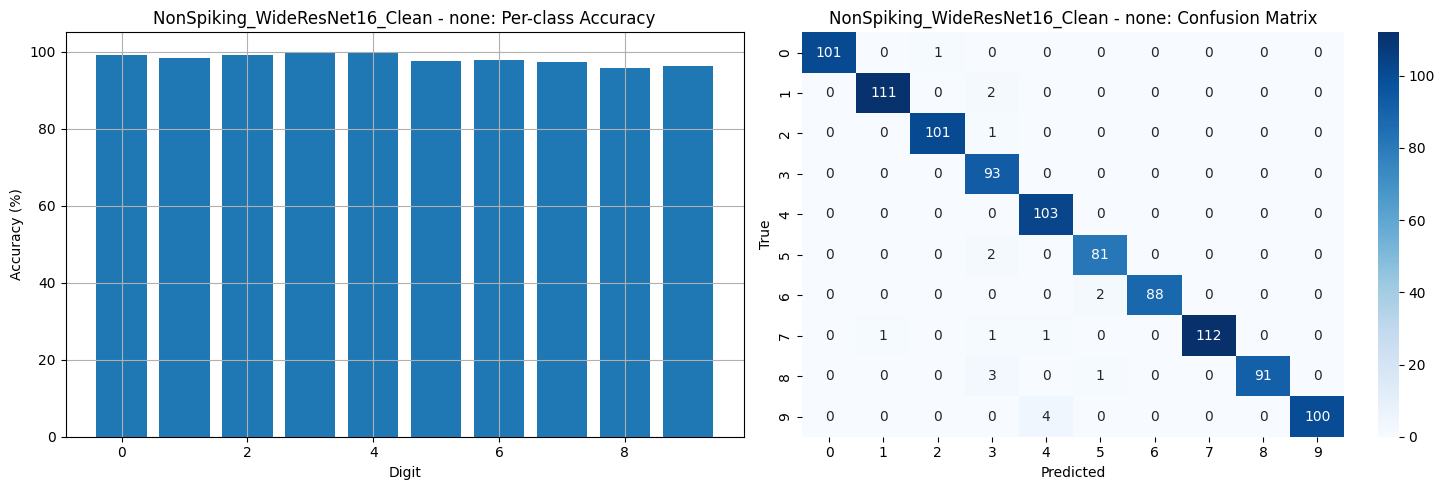

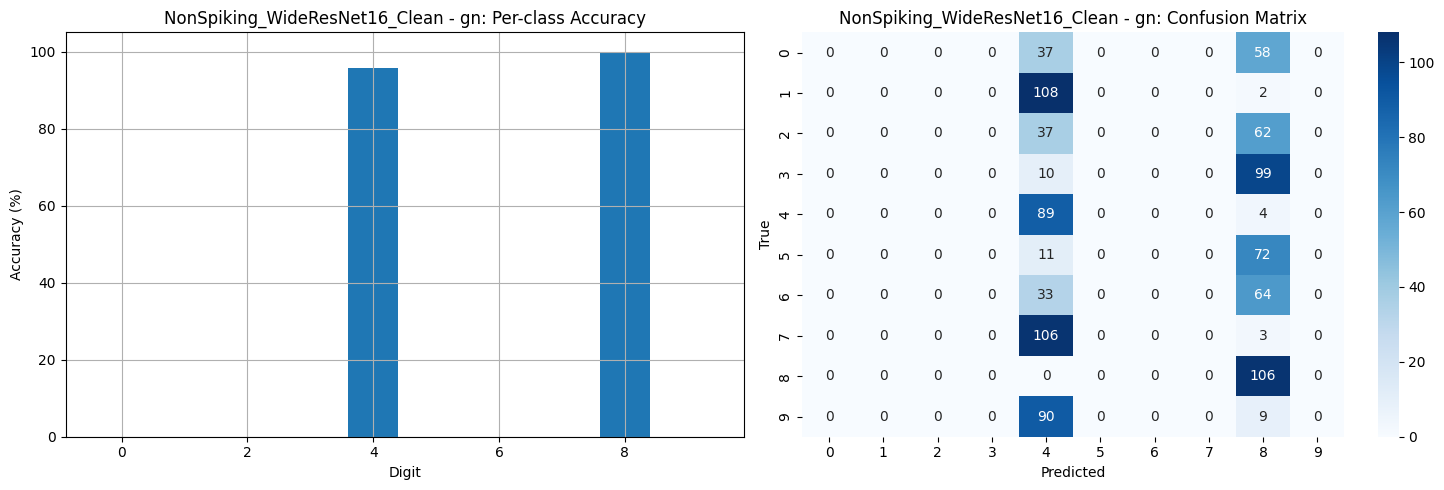

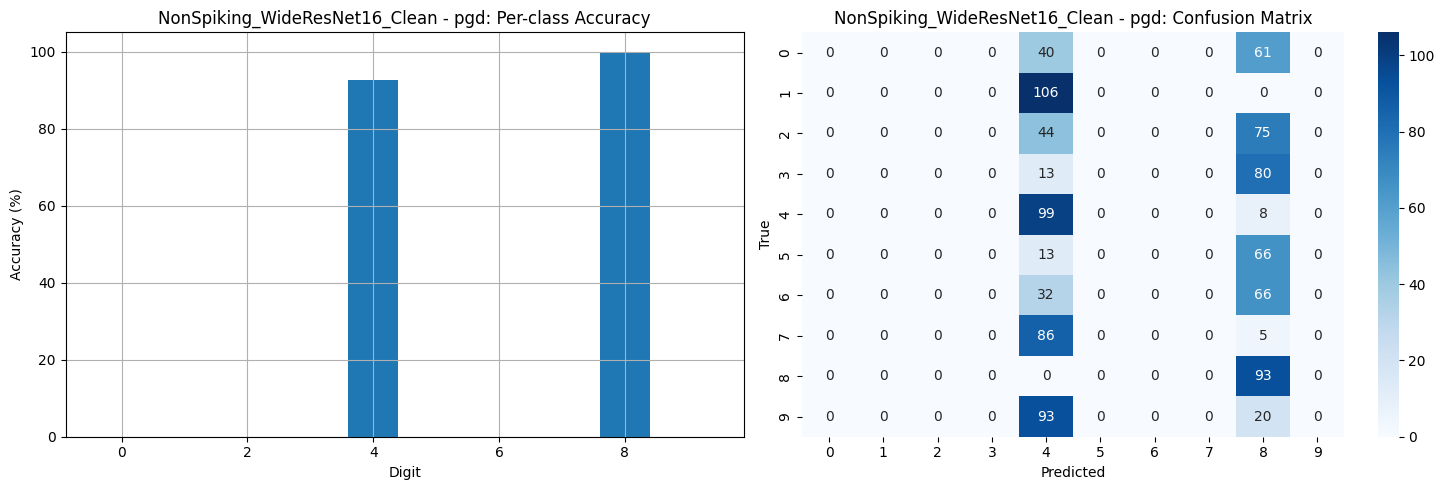

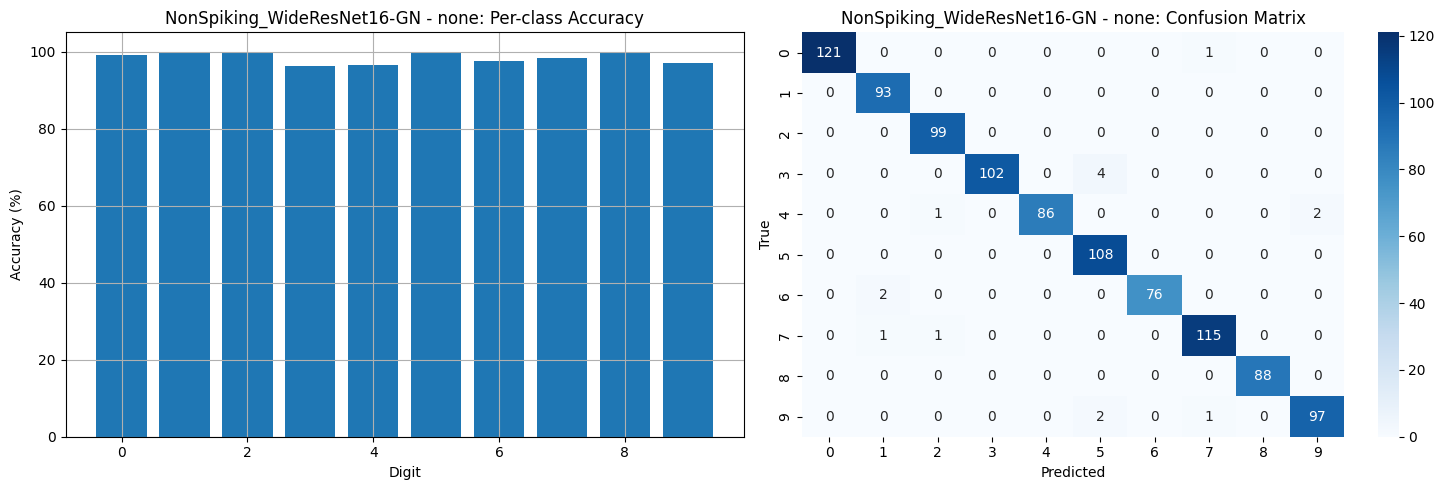

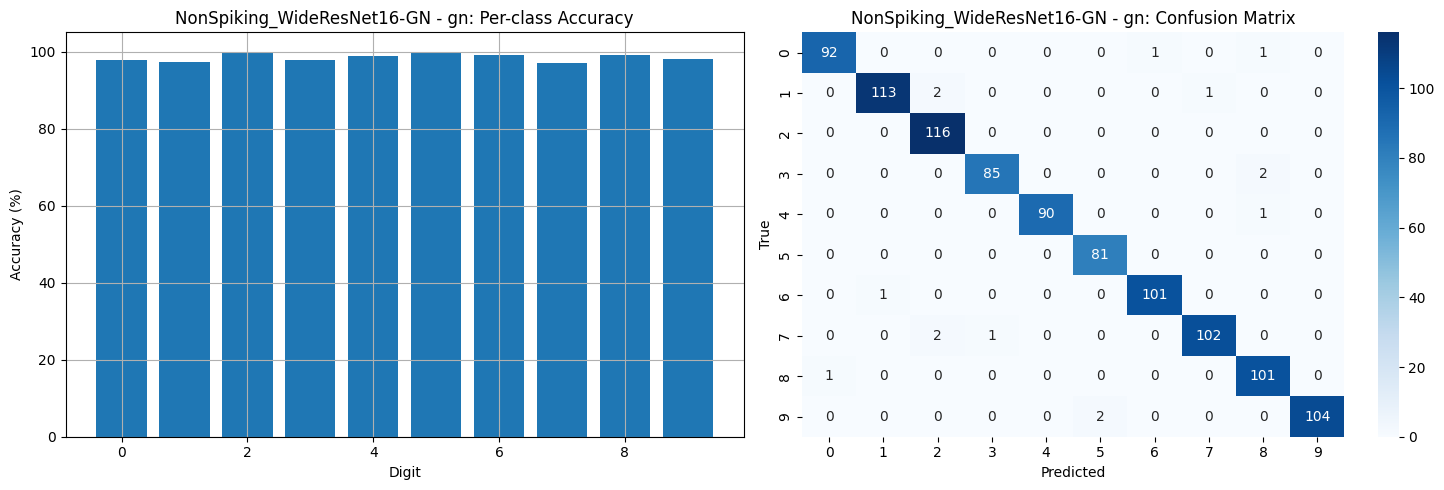

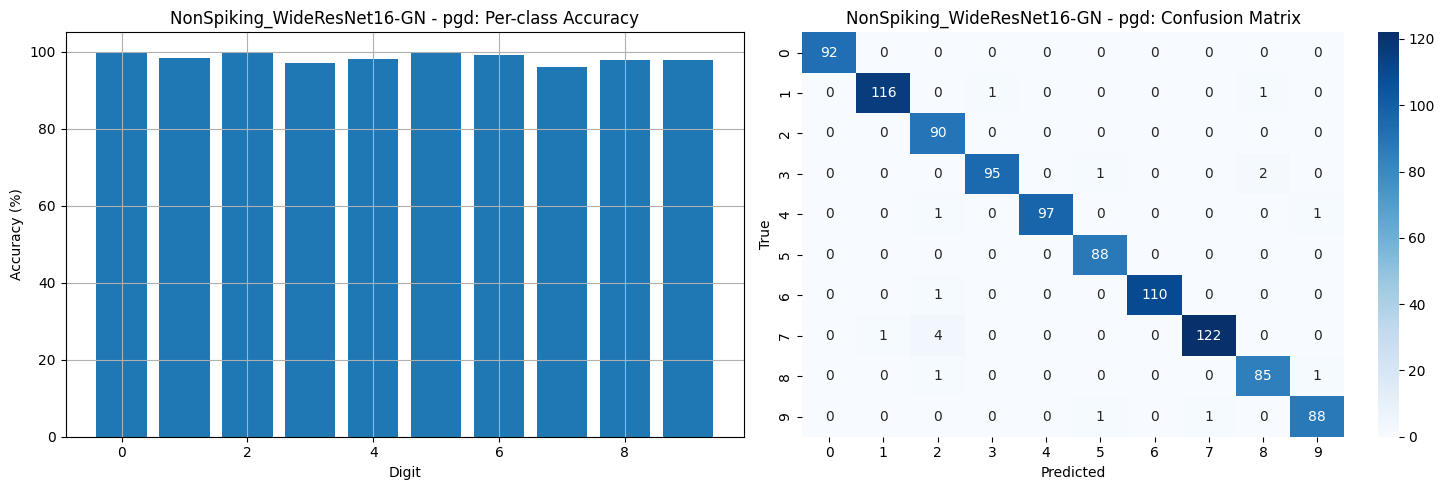

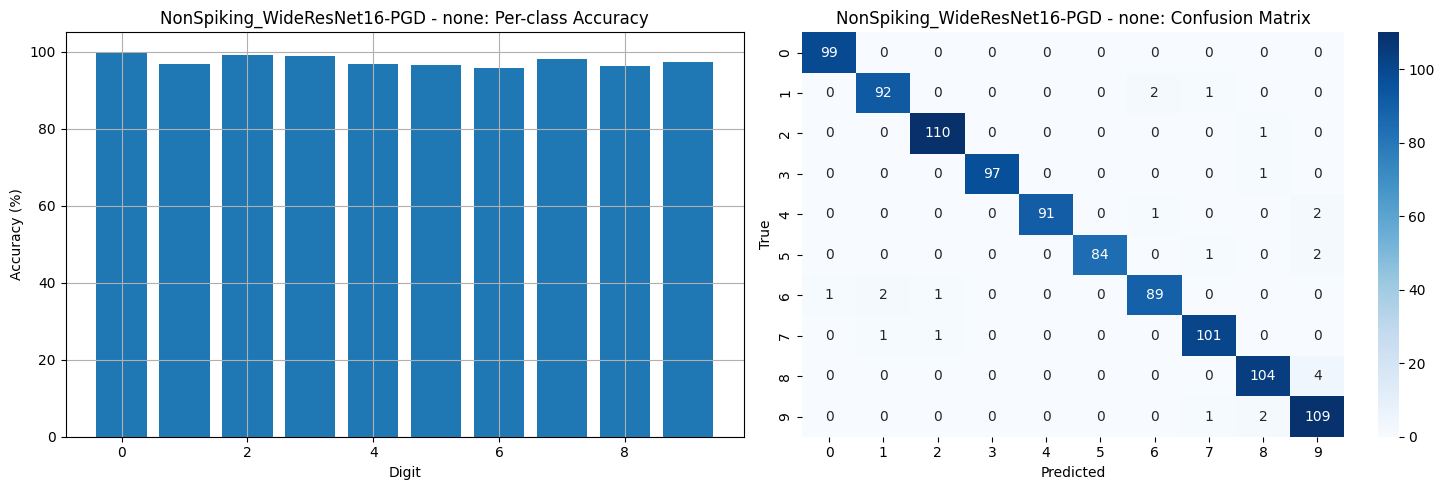

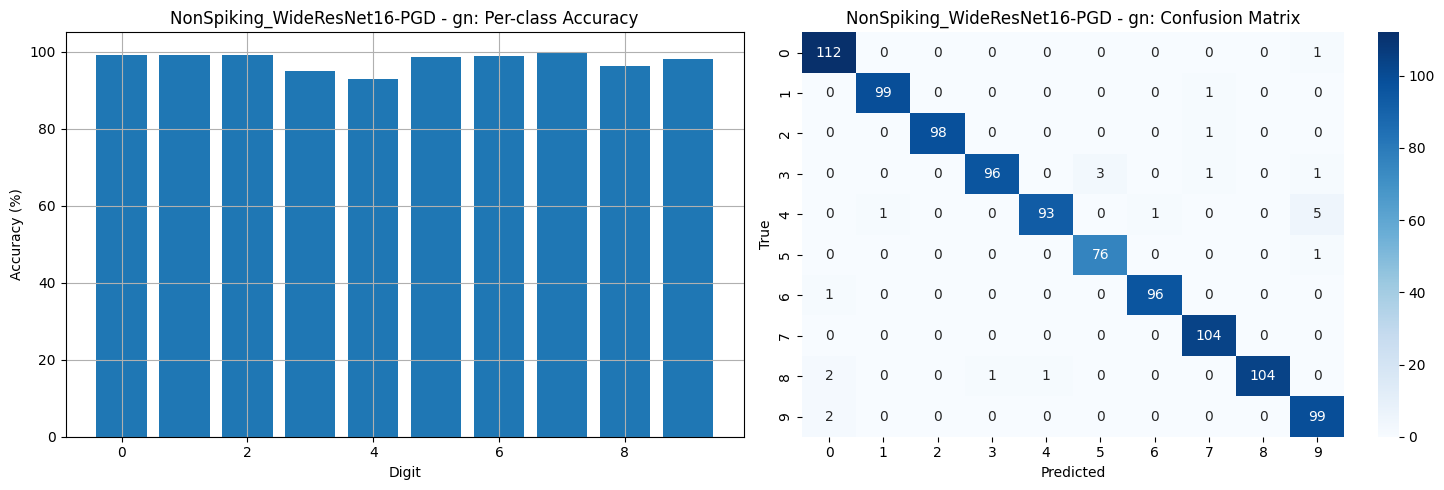

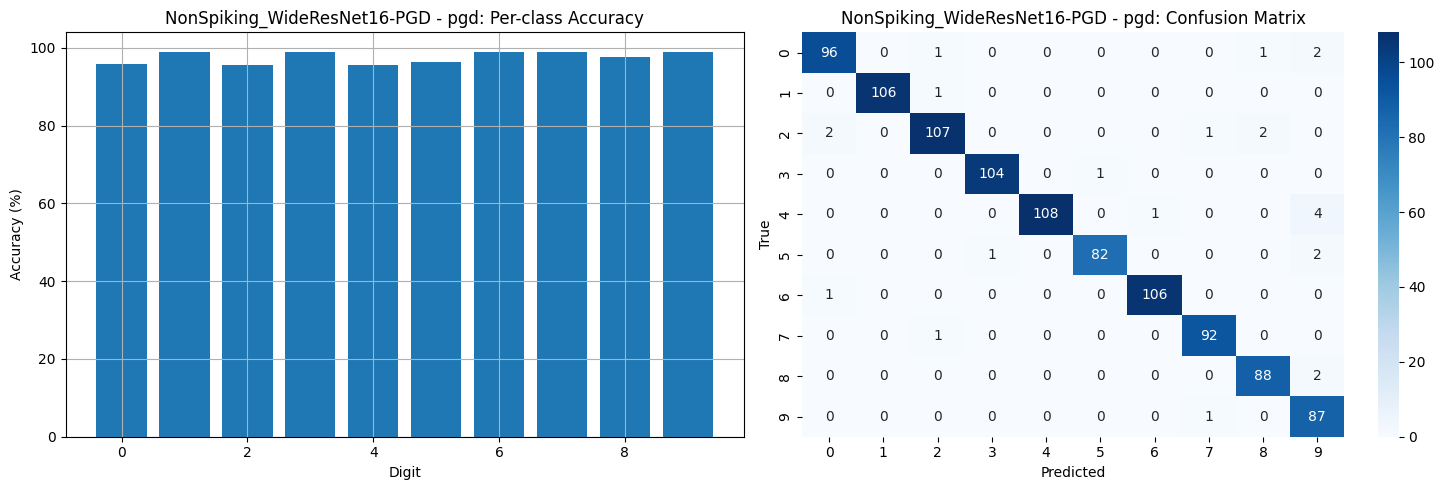

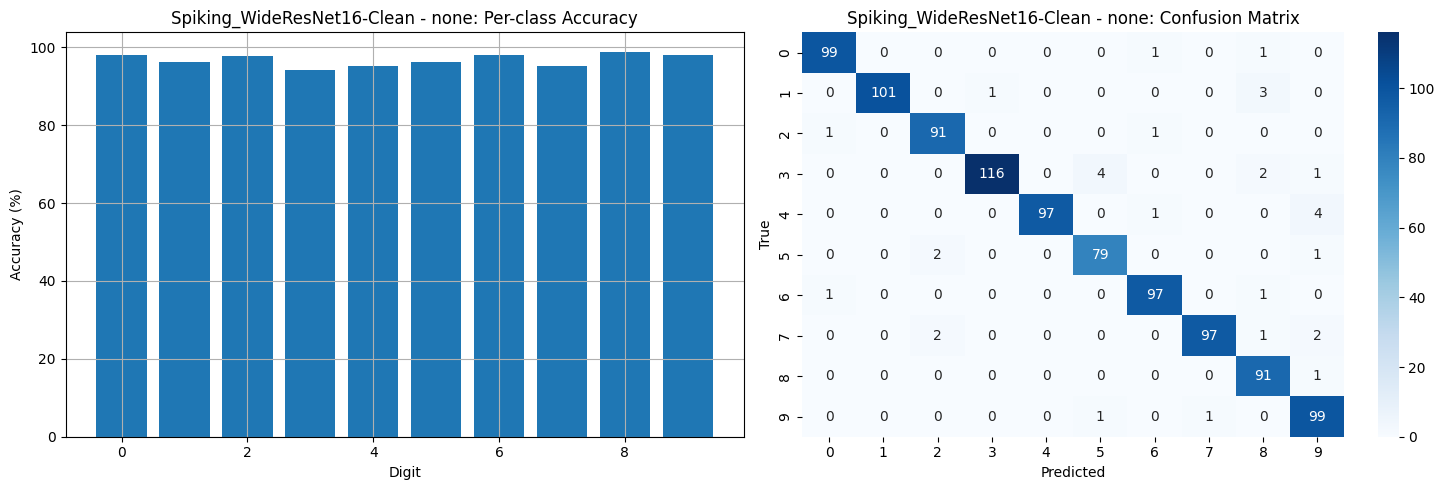

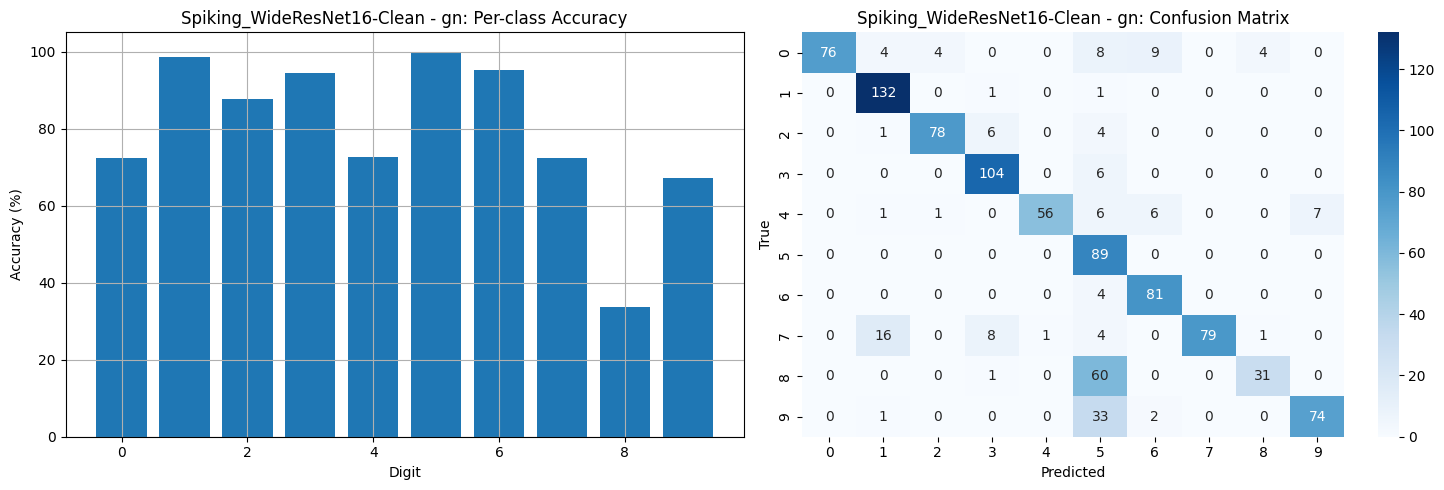

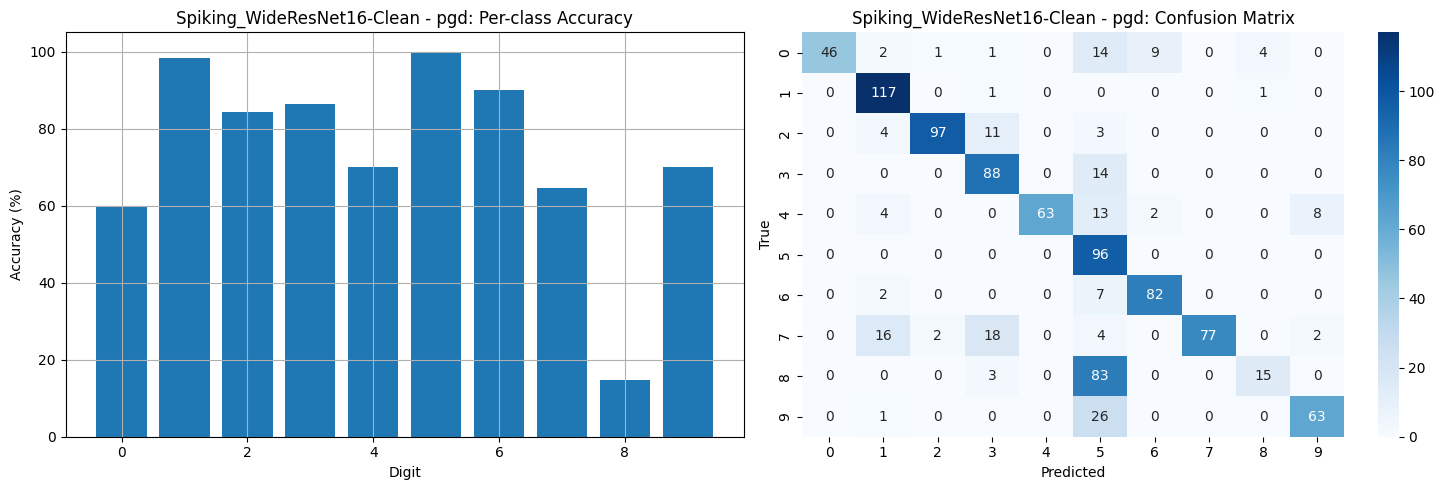

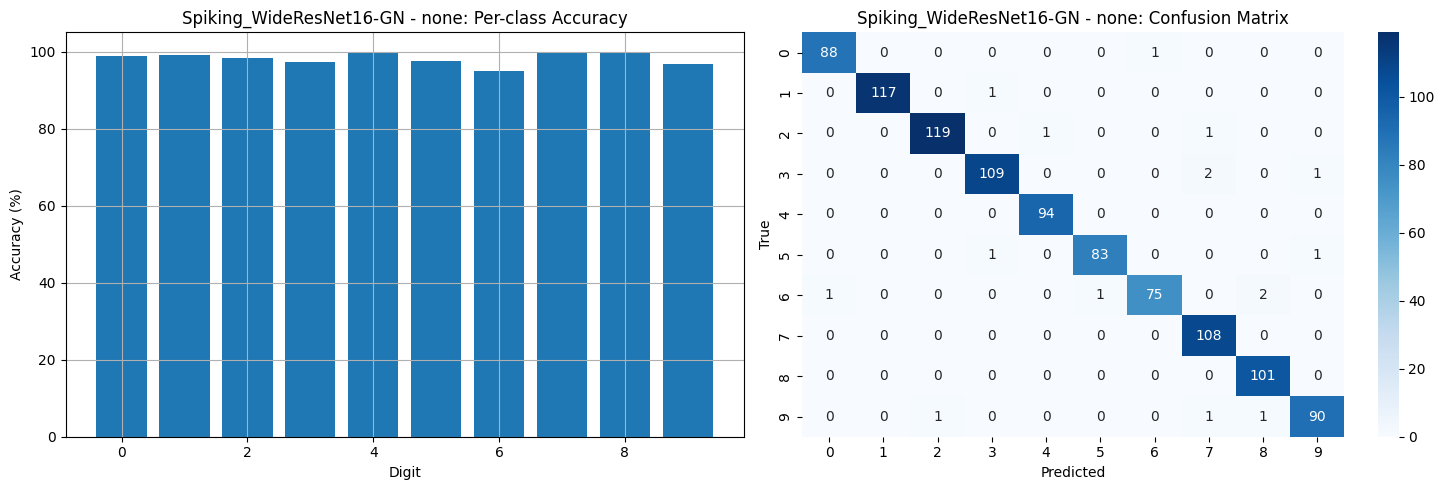

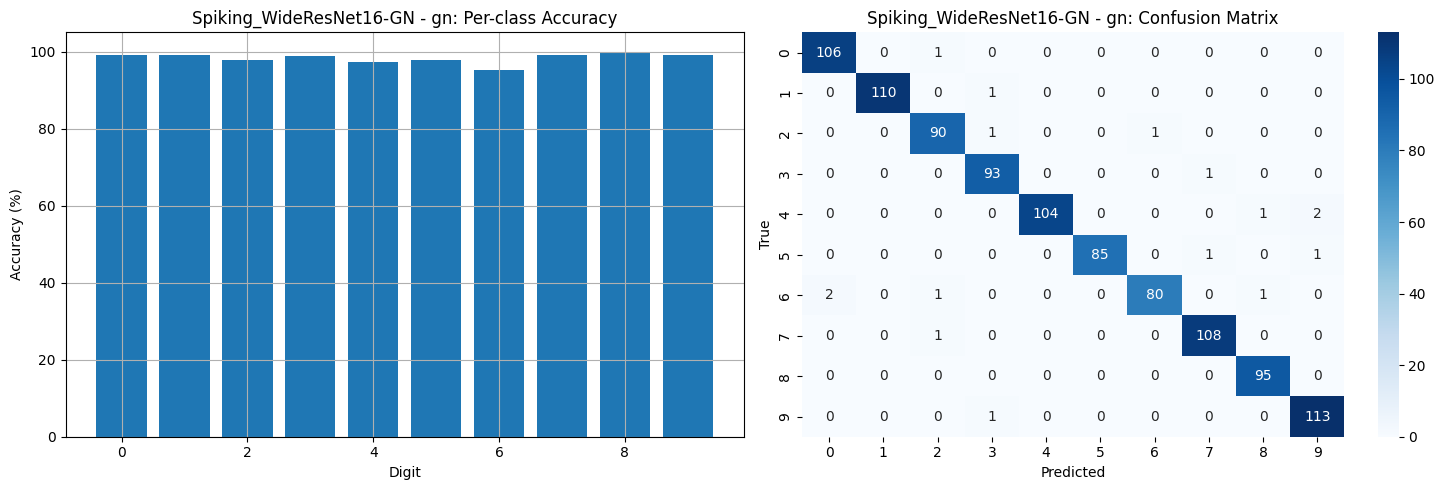

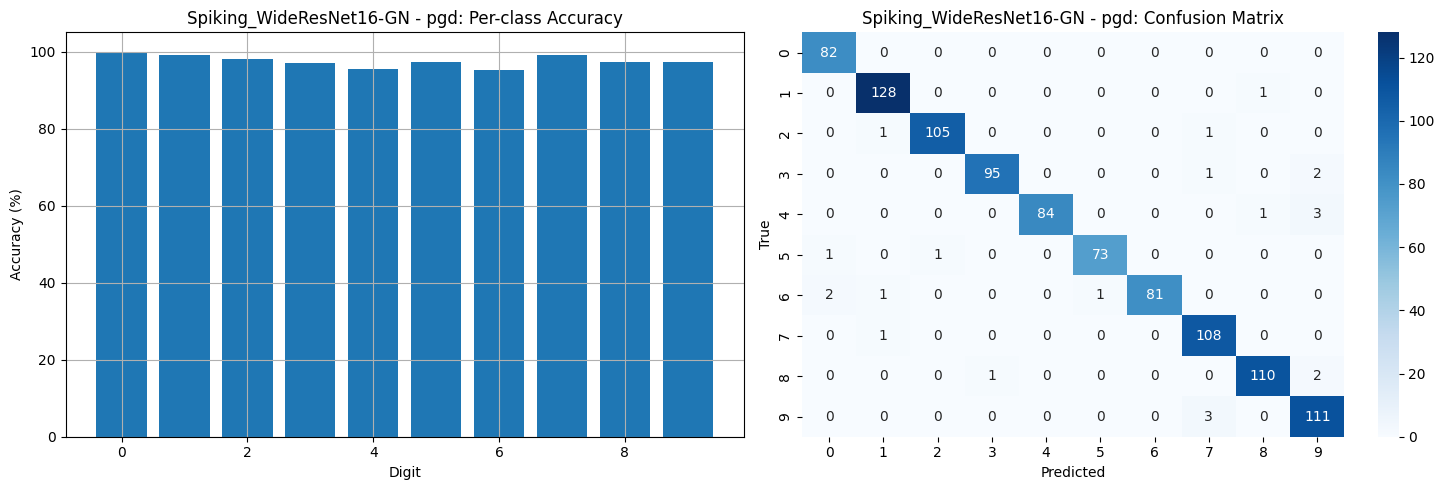

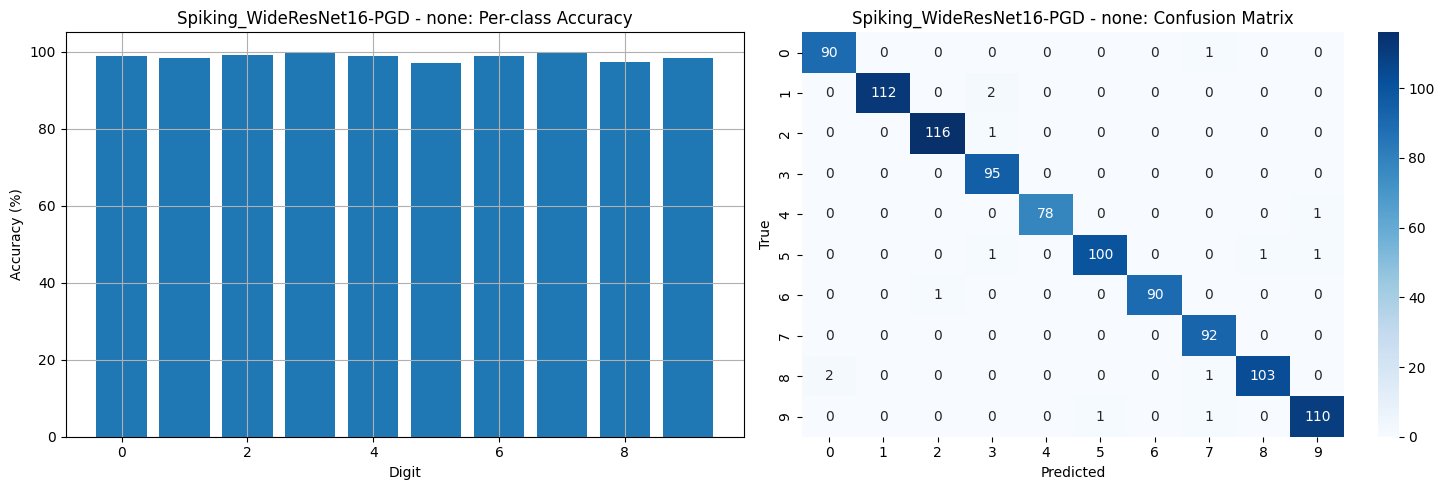

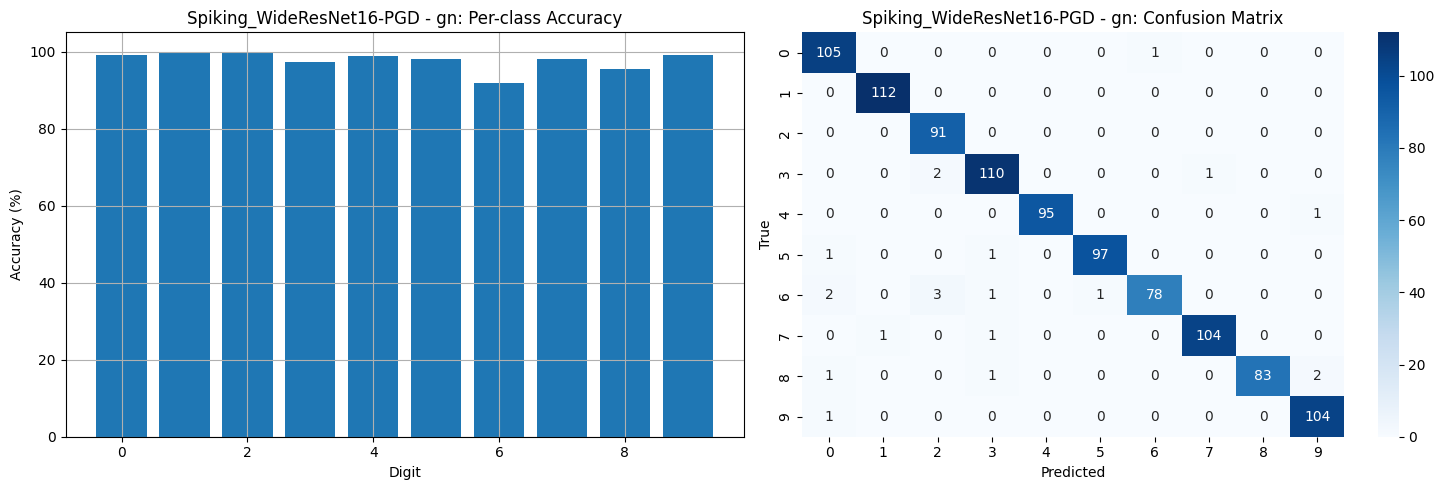

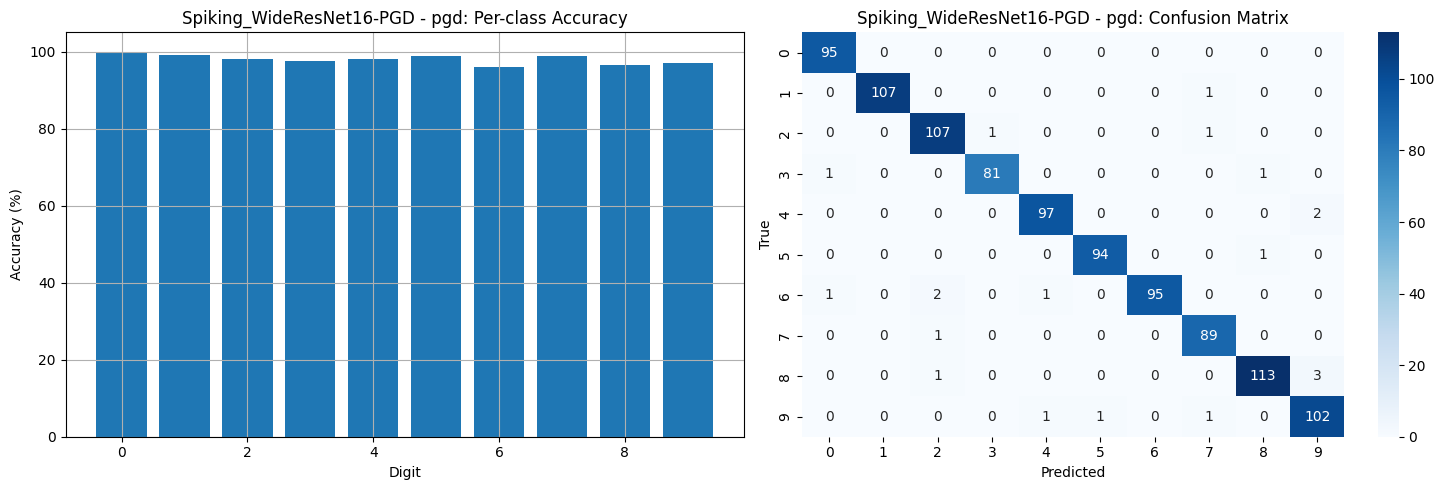

In [12]:
for config in configs:
    model_name = config['name']
    if model_name not in test_results:
        print(f"Warning: Model {model_name} not found in test results")
        continue
        
    for attack_name in ['none', 'gn', 'pgd']:
        if attack_name not in test_results[model_name]:
            print(f"Warning: Attack {attack_name} not found for model {model_name}")
            continue
            
        plt.figure(figsize=(15, 5))
        
        # Per-class accuracy bar plot
        plt.subplot(1, 2, 1)
        class_acc = test_results[model_name][attack_name]['class_accuracies']
        plt.bar(range(10), class_acc)
        plt.xlabel('Digit')
        plt.ylabel('Accuracy (%)')
        plt.title(f'{model_name} - {attack_name}: Per-class Accuracy')
        plt.grid(True)
        
        # Confusion matrix
        plt.subplot(1, 2, 2)
        conf_matrix = test_results[model_name][attack_name]['confusion_matrix']
        # Use '.0f' format for floats that should be displayed as integers
        sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'{model_name} - {attack_name}: Confusion Matrix')
        
        plt.tight_layout()
        plt.show()

In [13]:
# Attack Effectiveness Comparison

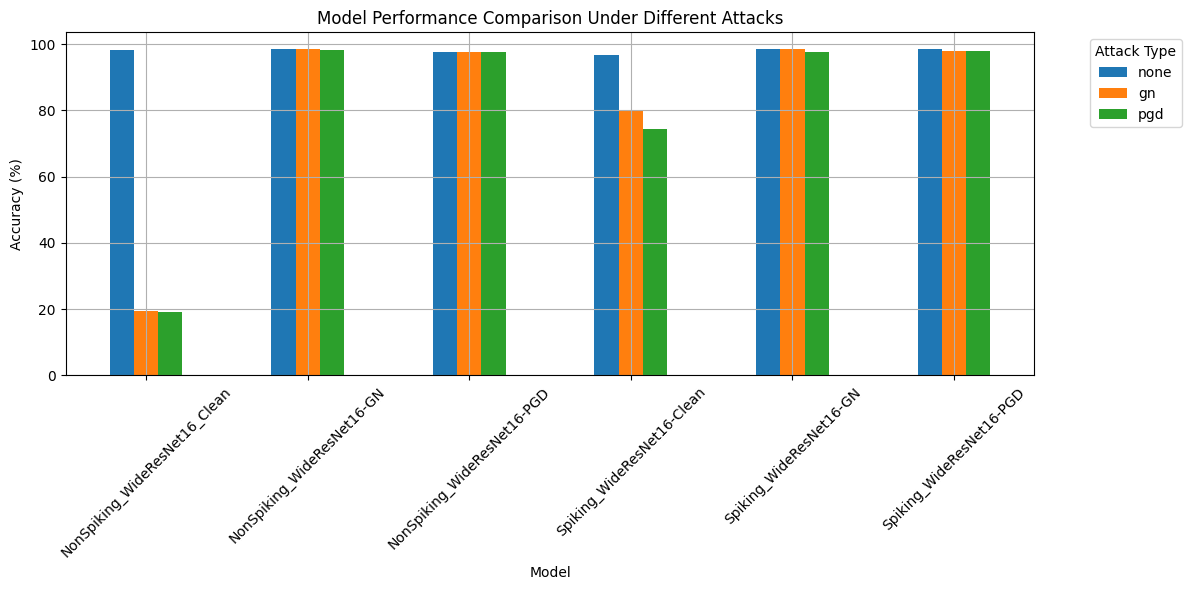

In [14]:
plt.figure(figsize=(12, 6))
x = np.arange(len(model_names))
width = 0.15
multiplier = 0

for attack_name in attack_names:
    attack_accuracies = [test_results[model_name][attack_name]['accuracy'] 
                       for model_name in model_names]
    offset = width * multiplier
    plt.bar(x + offset, attack_accuracies, width, label=attack_name)
    multiplier += 1

plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Model Performance Comparison Under Different Attacks')
plt.xticks(x + width * (len(attack_names)-1)/2, model_names, rotation=45)
plt.legend(title='Attack Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Summary Statistics

In [16]:
# Map your preferred display names to the actual keys in test_results
attack_name_mapping = {
    'Clean': 'none',
    'GN (weak)': 'gn',
    'PGD (strong)': 'pgd'
}

print("\nSummary Statistics:")
print("-" * 80)
# Update this header to match your preferred names
print(f"{'Model':<30} {'Clean':>10} {'GN (weak)':>10} {'PGD (strong)':>10}")
print("-" * 80)

for model_name in model_names:
    stats = []
    try:
        # Use the mapping to get the correct keys
        stats = [
            test_results[model_name][attack_name_mapping['Clean']]['accuracy'],
            test_results[model_name][attack_name_mapping['GN (weak)']]['accuracy'],
            test_results[model_name][attack_name_mapping['PGD (strong)']]['accuracy']
        ]
        
        print(f"{model_name:<30}", end="")
        for stat in stats:
            print(f"{stat:>10.2f}", end="")
        print()
    except KeyError as e:
        print(f"{model_name:<30} Error: Missing key {e}")


Summary Statistics:
--------------------------------------------------------------------------------
Model                               Clean  GN (weak) PGD (strong)
--------------------------------------------------------------------------------
NonSpiking_WideResNet16_Clean      98.10     19.50     19.20
NonSpiking_WideResNet16-GN         98.50     98.50     98.30
NonSpiking_WideResNet16-PGD        97.60     97.70     97.60
Spiking_WideResNet16-Clean         96.70     80.00     74.40
Spiking_WideResNet16-GN            98.40     98.40     97.70
Spiking_WideResNet16-PGD           98.60     97.90     98.00
